# The task is as follows
## Part 1
- Create a Python script that will get 1000 or more random users from https://random-data-api.com/documentation (Users) in json format.
- Save results about users in CSV file

## Part 2
- Read the CSV file you created in part one and load the data in the database of your choice.
- Create a query/algorithm that will find the most common user properties, and return them as a result.
- Create a query/algorithm that will find any similarities between users, that would suggest a "strong" or “weak (fuzzy)” connection between any 2 or more users IF that type of connection exists in the database.
- Create visualization representation of results with Matplotlib.

In [14]:
import logging
import random
import time
from csv import DictWriter
from pathlib import Path

import duckdb
import matplotlib.pyplot as plt
import requests

A few constants used in the succeeding sections.

In [15]:
logger = logging.getLogger("sport_serve")
BASE_DIR = Path('.').resolve()

Get 1000 or more random users from https://random-data-api.com/documentation in json format.

In [16]:
def get_users():
    users_count, attempt = 0, 0
    while users_count < random.randint(1_000, 1_500):
        size = random.randint(50, 100)
        try:
            response = requests.get(url=f"https://random-data-api.com/api/v2/users?size={size}")
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            extra = {"response": e.response.text}
            logger.exception("Failed to get users", extra=extra)
            if attempt > 4:
                raise
            timeout = pow(2, attempt) * 3
            logger.warning("Retrying in %s seconds...", timeout)
            time.sleep(timeout)
            attempt += attempt
        else:
            attempt = 0
            users = response.json()
            users_count += len(users)
            for user in users:
                yield user

Save users from API to a CSV file.

In [17]:
def save_users_to_csv(users):
    field_names = [
        "id",
        "uid",
        "password",
        "first_name",
        "last_name",
        "username",
        "email",
        "avatar",
        "gender",
        "phone_number",
        "social_insurance_number",
        "date_of_birth",
        # "employment",
        # "address",
        # "credit_card",
        # "subscription",
    ]
    users_csv = BASE_DIR / "sport_serve_users.csv"
    with open(users_csv, mode="w", encoding="utf-8") as f:
        writer = DictWriter(f, fieldnames=field_names)
        writer.writeheader()

        for user in users:
            writer.writerow(
                {
                    "id": user["id"],
                    "uid": user["uid"],
                    "password": user["password"],
                    "first_name": user["first_name"],
                    "last_name": user["last_name"],
                    "username": user["username"],
                    "email": user["email"],
                    "avatar": user["avatar"],
                    "gender": user["gender"],
                    "phone_number": user["phone_number"],
                    "social_insurance_number": user["social_insurance_number"],
                    "date_of_birth": user["date_of_birth"],
                },
            )
    return users_csv

In [18]:
csv_file = save_users_to_csv(users=get_users())
csv_file

Failed to get users
Traceback (most recent call last):
  File "/tmp/ipykernel_148038/380482667.py", line 7, in get_users
    response.raise_for_status()
  File "/sites/sportserve/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://random-data-api.com/api/v2/users?size=80
Retrying in 3 seconds...
Failed to get users
Traceback (most recent call last):
  File "/tmp/ipykernel_148038/380482667.py", line 7, in get_users
    response.raise_for_status()
  File "/sites/sportserve/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://random-data-api.com/api/v2/users?size=88
Retrying in 3 seconds...
Failed to get users
Traceback (most recent call last):
  File "/tmp/ipykernel_

PosixPath('/repos/python/jambo-customers/assignments/sport_serve_users.csv')

## Load CSV data in a database

We'll use DuckDb because it is optimised for Analytical queries, which is suitable for data science.

In [19]:
with duckdb.connect(database=BASE_DIR / "sportserve.db") as con:
    con.sql("DROP TABLE IF EXISTS users;")
    con.read_csv(csv_file).to_table(table_name="users")
    data_frame = con.query("SHOW TABLES").df()
data_frame

,name
0,users


## Most common values by Gender

In [20]:
query = """SELECT gender, COUNT(*) AS count
FROM users
GROUP BY gender
ORDER BY count DESC;"""

with duckdb.connect() as con:
    con.read_csv(csv_file).to_table(table_name="users")
    data_frame = con.sql(query=query).df()

data_frame

,gender,count
0,Genderfluid,181
1,Polygender,161
2,Genderqueer,159
3,Female,156
4,Non-binary,156
5,Male,148
6,Agender,137
7,Bigender,135


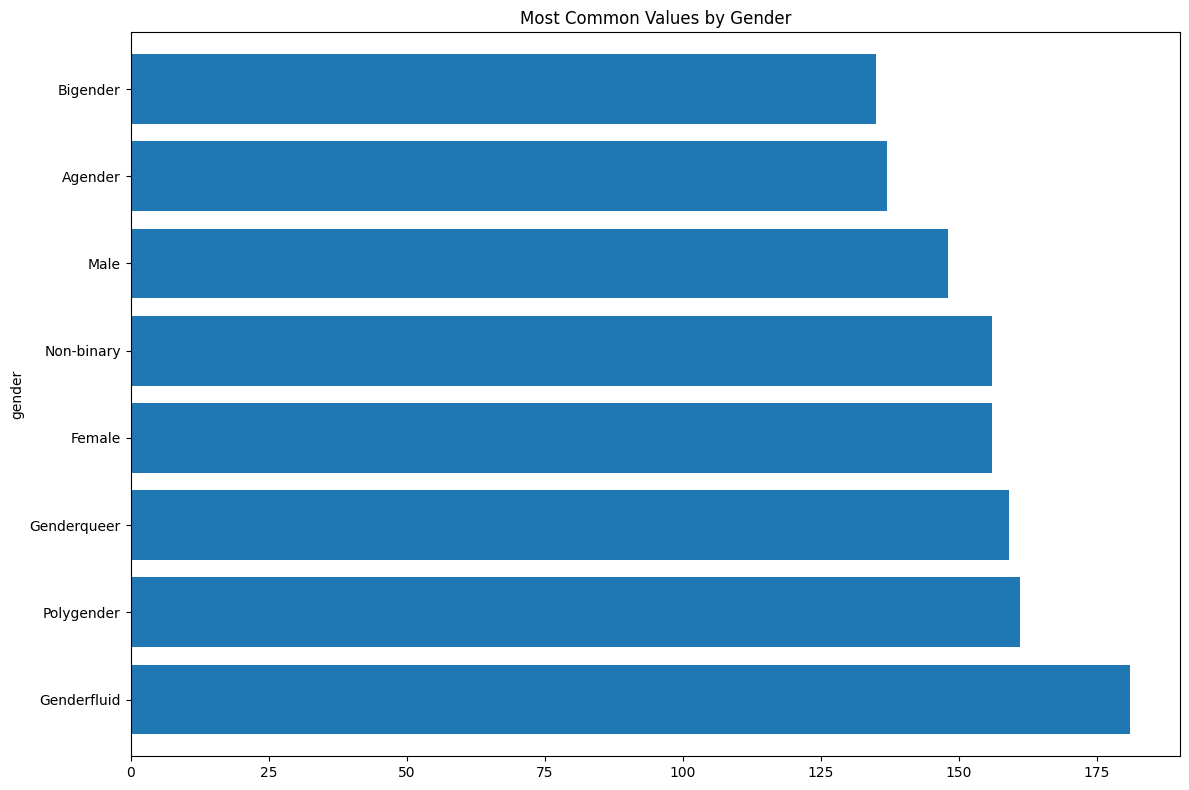

In [21]:
data_frame.plot.barh(
    x="gender",
    y="count",
    rot=0,
    figsize=(12, 8),
    title="Most Common Values by Gender",
    legend=False,
    width=0.8,
)
plt.tight_layout()
plt.show()

## Most common values by Generation
* **Greatest Generation:**
    * Born: Roughly 1901-1927
    * Characteristics: Grew up during the Great Depression and fought in World War II.

* **Silent Generation:**
    * Born: Roughly 1928-1945
    * Characteristics: Grew up during a time of conformity and traditional values.

* **Baby Boomers:**
    * Born: Roughly 1946-1964
    * Characteristics: Grew up during a period of social and cultural change, including the Civil Rights Movement and the Vietnam War.

* **Generation X:**
    * Born: Roughly 1965-1980
    * Characteristics: Grew up during a time of economic uncertainty and technological change, including the rise of personal computers and the internet.

* **Millennials (Generation Y):**
    * Born: Roughly 1981-1996
    * Characteristics: Grew up during a time of globalization and technological advancement, including the rise of social media and mobile devices.

* **Generation Z (Gen Z or Zoomers):**
    * Born: Roughly 1997-2012
    * Characteristics: Grew up in a digital world, with constant access to information and technology.

* **Generation Alpha:**
    * Born: Roughly 2013-Present
    * Characteristics: Growing up in a world of advanced technology, and are the children of millenials.

In [22]:
query = """WITH user_birth_years AS (SELECT CAST(EXTRACT(YEAR FROM date_of_birth) AS INTEGER) AS birth_year
                          FROM users)
SELECT CASE
           WHEN birth_year <= 1927 THEN 'Greatest'
           WHEN birth_year >= 1928 AND birth_year <= 1945 THEN 'Silent'
           WHEN birth_year >= 1946 AND birth_year <= 1964 THEN 'Baby Boomers'
           WHEN birth_year >= 1965 AND birth_year <= 1980 THEN 'Gen X'
           WHEN birth_year >= 1981 AND birth_year <= 1996 THEN 'Millennial (Gen Y)'
           WHEN birth_year >= 1997 AND birth_year <= 2012 THEN 'Zoomers (Gen Z)'
           WHEN birth_year >= 2013 THEN 'Gen Alpha'
           ELSE 'Unknown'
           END generation,
       COUNT(*) AS count
FROM user_birth_years
GROUP BY generation
ORDER BY count DESC;"""

with duckdb.connect() as con:
    con.read_csv(csv_file).to_table(table_name="users")
    data_frame = con.sql(query=query).df()

data_frame

,generation,count
0,Gen X,424
1,Millennial (Gen Y),416
2,Zoomers (Gen Z),261
3,Baby Boomers,132


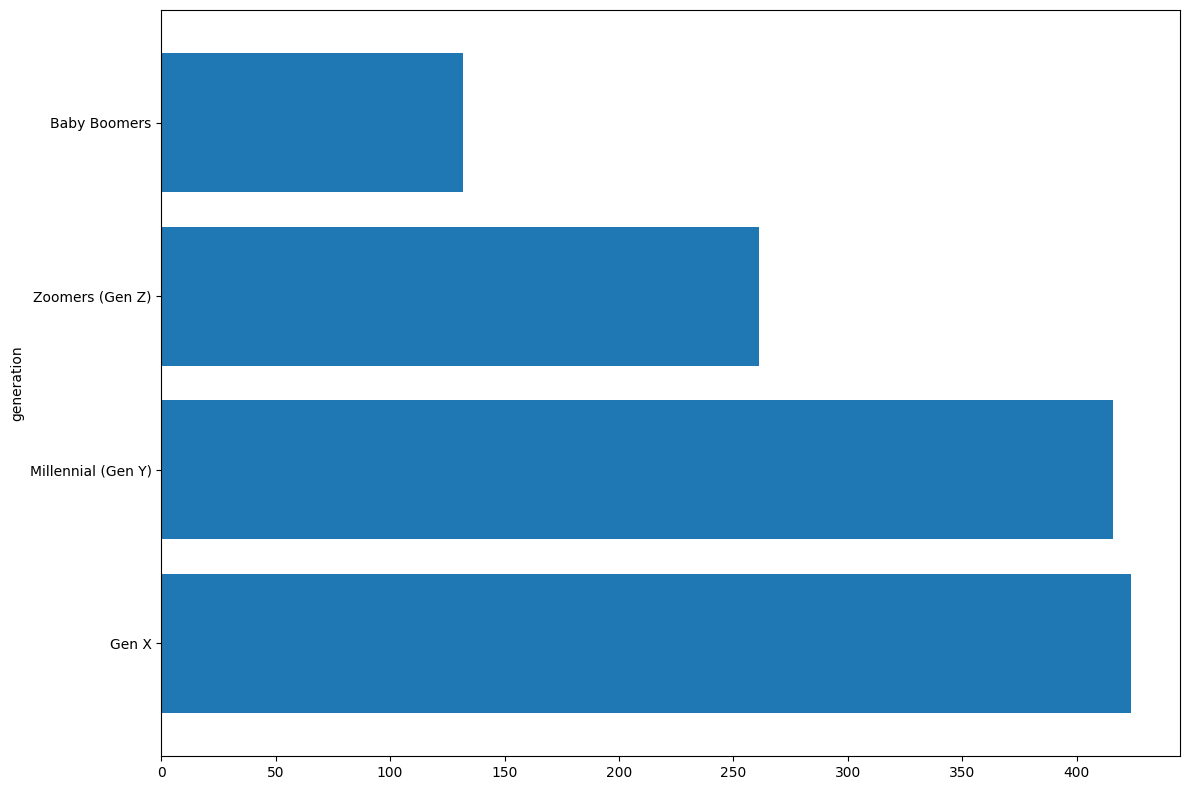

In [23]:
data_frame.plot.barh(
    x="generation",
    y="count",
    rot=0,
    figsize=(12, 8),
    legend=False,
    width=0.8,
)
plt.tight_layout()
plt.show()

## Show strong connection
Strong connection can be shown when for example, two users share the same phone numbers or email address.

### Strong connection shown through shared phone numbers

In [24]:
query = """SELECT u1.social_insurance_number sin_u1, u2.social_insurance_number sin_u2
FROM users AS u1, users AS u2
WHERE u1.uid != u2.uid AND u1.phone_number = u2.phone_number;"""

with duckdb.connect() as con:
    con.read_csv(csv_file).to_table(table_name="users")
    data_frame = con.sql(query=query).df()

data_frame

,sin_u1,sin_u2


### Strong connection shown through shared email address

In [25]:
query = """SELECT u1.social_insurance_number sin_u1, u2.social_insurance_number sin_u2
FROM users AS u1, users AS u2
WHERE u1.uid != u2.uid AND u1.email = u2.email;"""

with duckdb.connect() as con:
    con.read_csv(csv_file).to_table(table_name="users")
    data_frame = con.sql(query=query).df()

data_frame

,sin_u1,sin_u2
0,447625245,708174404
1,708174404,447625245


## Show weak/fuzzy connection
In the following section, we'll show a weak connection between two users if the first 3 characters in their names are same.

In [26]:
query = """SELECT u1.social_insurance_number sin_u1, u2.social_insurance_number sin_u2
FROM users AS u1, users AS u2
WHERE u1.uid != u2.uid AND u1.first_name LIKE '%' || SUBSTR(u2.first_name, 1, 3) || '%';"""

with duckdb.connect() as con:
    con.read_csv(csv_file).to_table(table_name="users")
    data_frame = con.sql(query=query).df()

data_frame

,sin_u1,sin_u2
0,980357123,257507343
1,742939028,257507343
2,254712920,257507343
3,543884365,257507343
4,161828934,257507343
...,...,...
5114,959384397,602379059
5115,516528932,602379059
5116,153767645,602379059
5117,757980008,602379059
